In [1]:
import numpy as np
from tqdm import tnrange
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
import os


In [2]:
# # Parameters for Sum of Difference graph
data_params3 = {
     "Training_dataset_Path": '/home/mabon/Tiny_power/datasets/power/xmega_unmasked/X1_K1_200k.npz', 
     "Training_traces": 150000,
     "numPOIs":10,
     "POIspacing": 1,
     "atk_input_path": '/home/mabon/Tiny_power/datasets/power/xmega_unmasked/X2_K2_100k.npz', #path to attack input file
     "atk_n": 5000,
     "target_byte": 2, # byte on which analysis is to be performed
     "attack_rounds": 1,
     "multi_plotter":True,
    "output_path_dir":"/home/mabon/temp"
}

In [3]:
# Retrieve Profiling Phase parameters
temp_path = data_params3['Training_dataset_Path']
trace_num = data_params3['Training_traces']
attack_rounds=data_params3['attack_rounds']
whole_pack = np.load(temp_path)

try:
    trace_array, textin_array, key = whole_pack['power_trace'], whole_pack['plain_text'], whole_pack['key']
except Exception:
    trace_array, textin_array, key = whole_pack['trace_mat'], whole_pack['textin_mat'], whole_pack['key']
trace_array = trace_array[:trace_num, :]
textin_array = textin_array[:trace_num, :]

tempTraces = trace_array
tempPText = textin_array

target_byte=data_params3['target_byte']

#Get key and real key
tempKey = key
real_key=key[target_byte]

In [4]:

# SBox used in AES
sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 
hw = [bin(x).count("1") for x in range(256)]

def cov(x, y):
    # Find the covariance between two 1D lists (x and y).
    # Note that var(x) = cov(x, x)
    return np.cov(x, y)[0][1]
def aes_internal(inputdata, key):
    key = int(key)
    inputdata = int(inputdata)
    return sbox[inputdata ^ key]

# Send XOR of our plaintext and key through S-Box
tempSbox = [aes_internal(tempPText[i][target_byte],tempKey[i % 16]) for i in range(len(tempPText))] 

# Retrieve HW of previous operation
tempHW   = [hw[s] for s in tempSbox]

# Sort HW of traces into groups by HW ( 9 groups total)
tempTracesHW = [[] for _ in range(9)]
for i in range(len(tempTraces)):
    HW = tempHW[i]
    tempTracesHW[HW].append(tempTraces[i])

# Switch to numpy arrays
tempTracesHW = [np.array(tempTracesHW[HW]) for HW in range(9)]


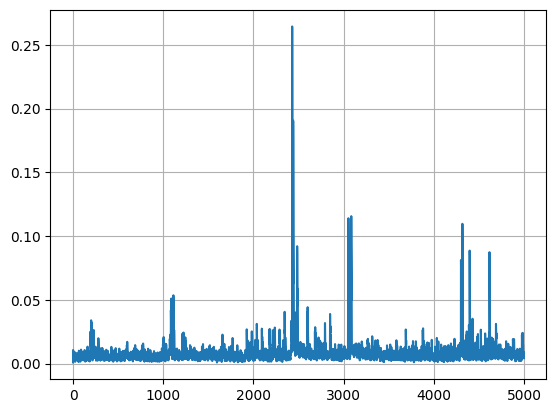

In [5]:
# 3: Find averages used to determine sum of differences
tempMeans = np.zeros((9, len(tempTraces[0])))
for i in range(9):
    tempMeans[i] = np.average(tempTracesHW[i], 0) 

# 4: Calculate sum of differences used to determine POIs
tempSumDiff = np.zeros(len(tempTraces[0]))
for i in range(9):
    for j in range(i):
        tempSumDiff += np.abs(tempMeans[i] - tempMeans[j])

plt.plot(tempSumDiff)
plt.grid()
plt.show()


In [6]:
# Retrieve POI parameters
POIs = []
numPOIs = data_params3['numPOIs']
POIspacing = data_params3['POIspacing']

# 5: Calculate POIs based upon sum of differences (choose peaks of POIs)
for i in range(numPOIs):
    # Find the max
    nextPOI = tempSumDiff.argmax()
    POIs.append(nextPOI)
    
    # Make sure we don't pick a nearby value
    poiMin = max(0, nextPOI - POIspacing)
    poiMax = min(nextPOI + POIspacing, len(tempSumDiff))
    for j in range(poiMin, poiMax):
        tempSumDiff[j] = 0
    
print("POIs: " + str(POIs))
# #print POIs
# tmp=[]
# for i in range(len(POIs)):
#     tmp.append(POIs[i]+1800)
# print("POIs: " + str(tmp))


POIs: [2430, 2431, 2441, 2442, 2432, 2433, 2443, 2437, 3085, 3053]


In [7]:
# 6: Fill up mean and covariance matrix for each HW
# Mean and Covariance matrixes used to create multivariate distributions in actual attack
meanMatrix = np.zeros((9, numPOIs))
covMatrix  = np.zeros((9, numPOIs, numPOIs))
for HW in tnrange(9):
    for i in range(numPOIs):
        # Calculate Mean for given HW
        meanMatrix[HW][i] = tempMeans[HW][POIs[i]]
        for j in range(numPOIs):
            #Calculate Covariance for given HW
            x = tempTracesHW[HW][:,POIs[i]]
            y = tempTracesHW[HW][:,POIs[j]]
            covMatrix[HW,i,j] = cov(x, y)
print("Templete Built")


/home/mabon/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/9 [00:00<?, ?it/s]

Templete Built


In [8]:
# 1: Load attack traces
temp_path = data_params3['atk_input_path']
trace_num = data_params3['atk_n']
whole_pack = np.load(temp_path)

try:
    trace_array, textin_array, key = whole_pack['power_trace'], whole_pack['plain_text'], whole_pack['key']
except Exception:
    trace_array, textin_array, key = whole_pack['trace_mat'], whole_pack['textin_mat'], whole_pack['key']
trace_array = trace_array[:trace_num, :]
textin_array = textin_array[:trace_num, :]

atkTraces = trace_array
atkPText = textin_array
atkKey = key
atkSize = trace_num

print("atk_input_path: " + str(temp_path))

atk_input_path: /home/mabon/Tiny_power/datasets/power/xmega_unmasked/X2_K2_100k.npz


In [9]:
def attack(trace_array, textin_array):
    #Randomize values for current run
    trace_array, textin_array = shuffle(trace_array, textin_array)
    atkTraces = trace_array
    atkPText = textin_array
    #P_k is an array containing the KRC for all guesses for the key.  As the value increases, the rank increases
    P_k = np.zeros(256)
    #Guess entropy array is used for graphing block
    guess_entropy=[]

    for j in range(len(atkTraces)):
        # Grab key points and put them in a small matrix
        a = [atkTraces[j][POIs[i]] for i in range(len(POIs))]
        # Test each guess
        for k in range(256):
            # Find HW coming out of sbox
            HW = hw[aes_internal(atkPText[j][target_byte],k)]
            # Find p_{k,j}
            rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
            p_kj = rv.pdf(a)
            #Add value to KRC of guess
            P_k[k] += np.log(p_kj)  
        guess_entropy.append(P_k.argsort())
    return(guess_entropy)

In [10]:
#Start of Attack Phase
print("Attack Start")
guess_entropy_mag=[]
print("atkKey: " + str(atkKey))

for h in tnrange(attack_rounds):
    temp=[]
    guess_entropy=attack(trace_array, textin_array)
    for i in range(len(guess_entropy)):
        temp.append(256-(list(guess_entropy[i]).index(real_key))-1)
    guess_entropy_mag.append(temp)

Attack Start
atkKey: [170 128 216 167 132 211  63  92  11 144 169 133  32 142 255  74]


/home/mabon/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/1 [00:00<?, ?it/s]

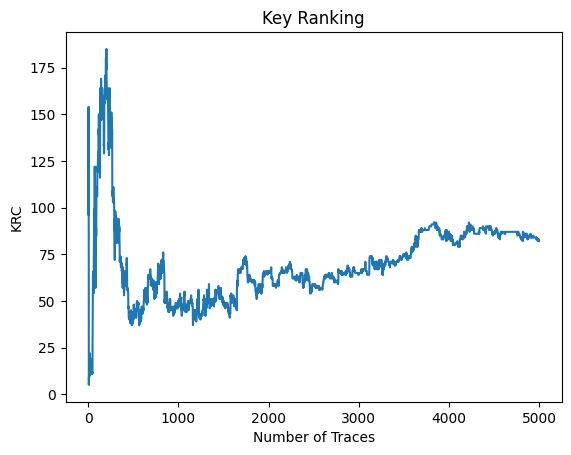

In [11]:
if data_params3['multi_plotter']==True:
    for i in range(len(guess_entropy_mag)):
        plt.plot(guess_entropy_mag[i])
    plt.title("Key Ranking")
    plt.xlabel('Number of Traces')
    plt.ylabel('KRC')

Text(0, 0.5, 'KRC')

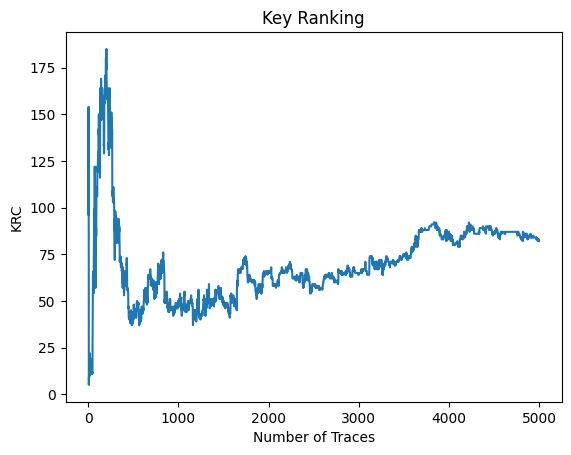

In [12]:
# Average the array across columns
average = np.mean(guess_entropy_mag, axis=0)
average
plt.plot(average)
plt.title("Key Ranking")
plt.xlabel('Number of Traces')
plt.ylabel('KRC')


In [13]:
#python program to check if a directory exists

path =  data_params3["output_path_dir"]
model_save_file = os.path.join(path, 'test_trace.npz')
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new directory is created!")
np.savez(model_save_file,y=average)
print(model_save_file)

/home/mabon/temp/test_trace.npz
